In [1]:
import pandas as pd
df1 = pd.read_csv('dialect_dataset.csv')
df2 = pd.read_csv('retreived_text_data.csv')
x = df2['text']

# Factorizing the label column in the train and test dataframes:
df1['label_id']=df1['dialect'].factorize()[0]
display(df1[['dialect','label_id']].drop_duplicates())
y = df1['label_id']

,dialect,label_id
0,IQ,0
15497,LY,1
51996,QA,2
83065,PL,3
126807,SY,4
143049,TN,5
152295,JO,6
180216,MA,7
191755,SA,8
218587,YE,9


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words(['arabic','english']))

# Applying the clean_text function to the dataframe:
def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    text = re.sub(r'([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+', '' , text)
    text = text.rstrip()
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

display(x.head(), x.tail())
x = x.apply(clean_text)
display(x.head(), x.tail())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abdelrahman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0     @Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1    @7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2                      @KanaanRema مبين من كلامه خليجي
3           @HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4                   @hmo2406 وين هل الغيبه  اخ محمد 🌸🌺
Name: text, dtype: object

458192                @Al_mhbaa_7 مبسوطين منك اللي باسطانا😅
458193         @Zzainabali @P_ameerah والله ماينده ابش يختي
458194    @Al_mhbaa_7 شو عملنا لك حنا تهربي مننا احنا مس...
458195          @haneenalmwla الله يبارك فيها وبالعافيه 😋😋😋
458196            @jolnar121 السحله ضيفي ي بتطلع لك سحليه😅😅
Name: text, dtype: object

0                                  بالنهاية ينتفض يغير
1    يعني محسوب البشر حيونه ووحشيه وتطلبون الغرب يح...
2                                     مبين كلامه خليجي
3                            يسلملي مرورك وروحك الحلوه
4                                   وين الغيبه اخ محمد
Name: text, dtype: object

458192                             مبسوطين منك اللي باسطانا
458193                                والله ماينده ابش يختي
458194    شو عملنا حنا تهربي مننا احنا مساكين ليش بتعملي...
458195                                 الله يبارك وبالعافيه
458196                              السحله ضيفي بتطلع سحليه
Name: text, dtype: object

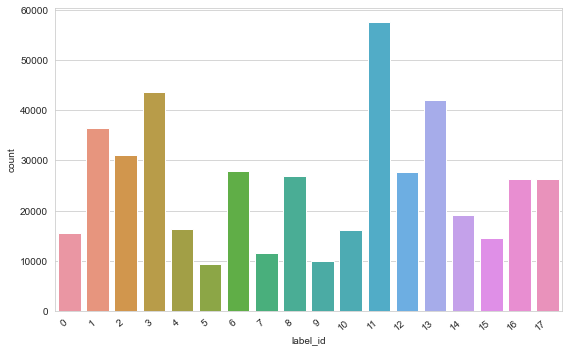

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import  Dropout, Dense
from sklearn import metrics
from tensorflow.keras.layers import SpatialDropout1D, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
tokenizer.fit_on_texts(x.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
x = tokenizer.texts_to_sequences(x.values)
x = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x.shape)
print('Shape of label tensor:', y.shape)

Found 513351 unique tokens.
Shape of data tensor: (458197, 250)
Shape of label tensor: (458197,)


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y)

In [9]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=x.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(18, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3
batch_size = 64

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
6444/6444 [==============================] - 11983s 2s/step - loss: 1.8159 - accuracy: 0.4275 - val_loss: 1.5723 - val_accuracy: 0.5095
Epoch 2/3
6444/6444 [==============================] - 11943s 2s/step - loss: 1.3984 - accuracy: 0.5603 - val_loss: 1.5301 - val_accuracy: 0.5239
Epoch 3/3
6444/6444 [==============================] - 11985s 2s/step - loss: 1.2247 - accuracy: 0.6140 - val_loss: 1.5681 - val_accuracy: 0.5205


1432/1432 [==============================] - 216s 151ms/step - loss: 1.5681 - accuracy: 0.5205
Test set
  Loss: 1.568
  Accuracy: 0.521


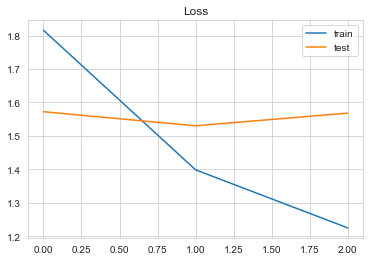

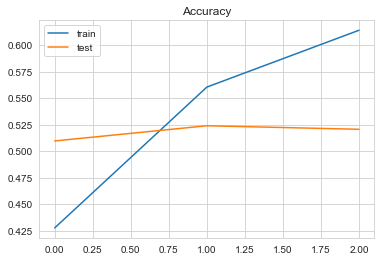

In [12]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
# plotting loss
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
# plotting accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [11]:
model.save('dl_model.h5')